# League of Legends analysis
This project's aim is to:
- analyze the differences between the Red and Blue side
- find the main factors that influence a game
- construct a model that can predict the outcome of a game based on the early game scoreboard information 

Dataset: https://www.kaggle.com/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min

In [786]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [787]:
import warnings
warnings.filterwarnings('ignore')

In [788]:
df = pd.read_csv('high_diamond_ranked_10min.csv')

# Data cleaning

In [789]:
df.notna().all().all() # No missing values found in dataset

True

Let's reorganize the dataframe. I want to split the different teams, then join them again later in the same dataframe to create a cleaner dataset for our analysis.

In [790]:
df.columns

Index(['gameId', 'blueWins', 'blueWardsPlaced', 'blueWardsDestroyed',
       'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists',
       'blueEliteMonsters', 'blueDragons', 'blueHeralds',
       'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin', 'redWardsPlaced', 'redWardsDestroyed',
       'redFirstBlood', 'redKills', 'redDeaths', 'redAssists',
       'redEliteMonsters', 'redDragons', 'redHeralds', 'redTowersDestroyed',
       'redTotalGold', 'redAvgLevel', 'redTotalExperience',
       'redTotalMinionsKilled', 'redTotalJungleMinionsKilled', 'redGoldDiff',
       'redExperienceDiff', 'redCSPerMin', 'redGoldPerMin'],
      dtype='object')

In [791]:
blue_columns = ['gameId']
red_columns = ['gameId']

for col in df.columns:
    if 'blue' in col:
        blue_columns += [col]
    if 'red' in col:
        red_columns += [col]


In [792]:
blue_df = df[blue_columns]

In [793]:
blue_df['blueWins'].value_counts()

blueWins
0    4949
1    4930
Name: count, dtype: int64

In [794]:
red_df = df[red_columns]

In [795]:
red_df['redWins'] = 1 - df['blueWins']

In [796]:
red_df.head()

,gameId,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,...,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,redWins
0,4519157822,15,6,0,6,9,8,0,0,0,...,16567,6.8,17047,197,55,-643,8,19.7,1656.7,1
1,4523371949,12,1,1,5,5,2,2,1,1,...,17620,6.8,17438,240,52,2908,1173,24.0,1762.0,1
2,4521474530,15,3,1,11,7,14,0,0,0,...,17285,6.8,17254,203,28,1172,1033,20.3,1728.5,1
3,4524384067,15,2,1,5,4,10,0,0,0,...,16478,7.0,17961,235,47,1321,7,23.5,1647.8,1
4,4436033771,17,2,1,6,6,7,1,1,0,...,17404,7.0,18313,225,67,1004,-230,22.5,1740.4,1


# Side advantage

## Win rate

Let's first check the probability of Blue team winning

In [797]:
wins = df['blueWins']

In [798]:
wins.value_counts()[1]/len(wins)

0.4990383642069035

It seems that the value converges to 0.5
Let's conduct a t-test just to be sure

In [799]:
from scipy import stats

Ho: won games mean is 0.5 (no side has any advantage)

Ha: won games mean is different from 0.5 

In [800]:
t_statistic, p_value = stats.ttest_1samp(wins, 0.5)

print("T-statistic:", t_statistic)
print("P-value:", p_value)

if p_value < 0.05:
    print("Reject the null hypothesis: The mean is significantly different from 0.5")
else:
    print("Fail to reject the null hypothesis: The mean is not significantly different from 0.5")

T-statistic: -0.1911507162408147
P-value: 0.8484114428598137
Fail to reject the null hypothesis: The mean is not significantly different from 0.5


The P-value is very high, which means that there is a lot of reason to expect that the true population mean of the won games is 0.5. Therefore, we do not reject the null hypothesis.

Knowing that the side of the map has no statistical impact in the chances of winning, let's check some parameters that determine the winning chances.

## Data Reorganization

Let's continue to reorganize the data

In [801]:
blue_columns = blue_df.columns
blue_dict = {}

for col in blue_columns:
    if 'blue' in col:
        blue_dict[col] = col.replace('blue', '')


In [802]:
blue_df.rename(columns=blue_dict, inplace=True)

In [803]:
red_columns = red_df.columns
red_dict = {}

for col in red_columns:
    if 'red' in col:
        red_dict[col] = col.replace('red', '')

In [804]:
red_df.rename(columns=red_dict, inplace=True)

In [805]:
data = pd.concat([red_df, blue_df], ignore_index=True, sort=False)

In [806]:
len(data) == len(red_df) + len(blue_df)

True

In [807]:
(data['gameId'].value_counts() == 2).all() 

True

It seems that the data has been merged correctly

In [808]:
data.head()

,gameId,WardsPlaced,WardsDestroyed,FirstBlood,Kills,Deaths,Assists,EliteMonsters,Dragons,Heralds,...,TotalGold,AvgLevel,TotalExperience,TotalMinionsKilled,TotalJungleMinionsKilled,GoldDiff,ExperienceDiff,CSPerMin,GoldPerMin,Wins
0,4519157822,15,6,0,6,9,8,0,0,0,...,16567,6.8,17047,197,55,-643,8,19.7,1656.7,1
1,4523371949,12,1,1,5,5,2,2,1,1,...,17620,6.8,17438,240,52,2908,1173,24.0,1762.0,1
2,4521474530,15,3,1,11,7,14,0,0,0,...,17285,6.8,17254,203,28,1172,1033,20.3,1728.5,1
3,4524384067,15,2,1,5,4,10,0,0,0,...,16478,7.0,17961,235,47,1321,7,23.5,1647.8,1
4,4436033771,17,2,1,6,6,7,1,1,0,...,17404,7.0,18313,225,67,1004,-230,22.5,1740.4,1


## Dragon / Herald 

Does the side of the map have an impact on Dragon/Herald kills?

In [809]:
population_mean_dragon = np.mean(data['Dragons'])
population_mean_herald = np.mean(data['Heralds'])

blue_mean_dragon = np.mean(blue_df['Dragons'])
blue_mean_herald = np.mean(blue_df['Heralds'])

red_mean_dragon = np.mean(red_df['Dragons'])
red_mean_herald = np.mean(red_df['Heralds'])

### Dragon

In [810]:
def bar_plot_parameter(df, param, bins):
    plt.hist(df[param],bins)
    plt.xticks(range(0,max(data[param]+1)))
    plt.title(f'Early Game {param}')
    plt.xlabel(f'{param}')
    plt.ylabel('Frequency')
    plt.axvline(np.mean(df[param]), color='red')
    plt.text(np.mean(df[param]), plt.ylim()[1]*0.9, f'Mean: {np.mean(df[param]):.2f}', color='black', ha='right')
    plt.show()

General

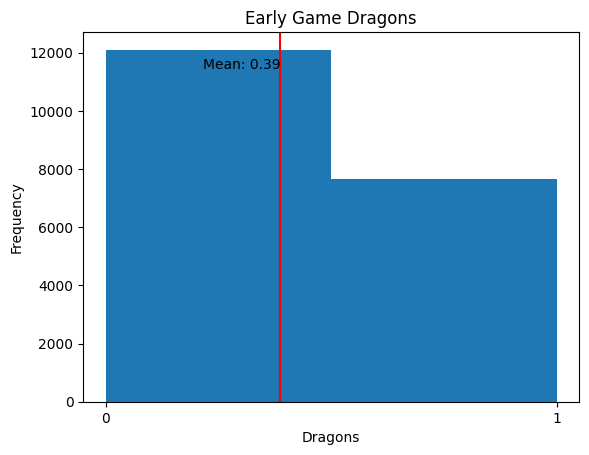

In [811]:
bar_plot_parameter(data, 'Dragons', bins=2)

Blue side

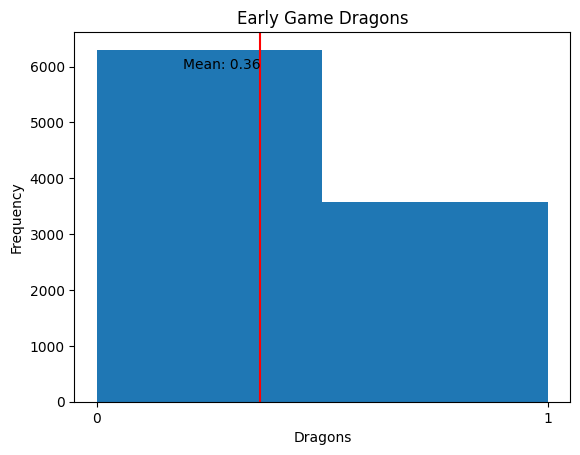

In [812]:
bar_plot_parameter(blue_df, 'Dragons', bins=2)

Red side

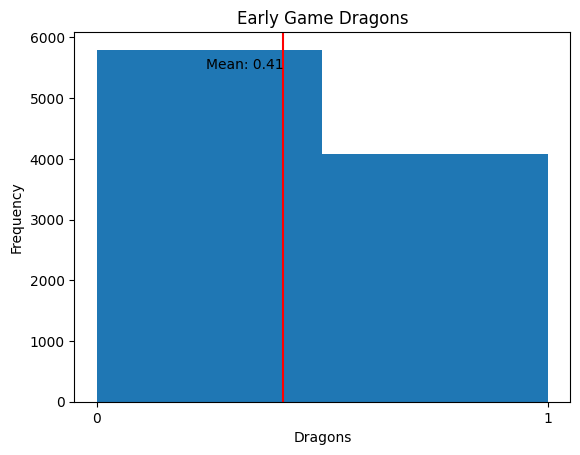

In [813]:
bar_plot_parameter(red_df, 'Dragons', bins=2)

We can see that, on average, the red side slains more dragons than the blue side

Let's check if the blue side is at a disadvantage in this scenario

In [814]:
#Ho: blue_mean = mu
#Ha: blue_mean < mu
alpha = 0.05
population_mean = np.mean(data['Dragons'])
population_sd = np.std(data['Dragons'])
sample_mean = np.mean(blue_df['Dragons'])
sample_n = len(blue_df['Dragons'])
z = (sample_mean - population_mean)/(population_sd/np.sqrt(sample_n))

z_critical = stats.norm.ppf(alpha)

In [815]:
z < z_critical

True

We consider the alternative hypothesis. Therefore, we can consider that the blue side could have a disadvantage when it comes to slaying the first Dragon

### Herald

Is the herald in blue's favor, though?

General

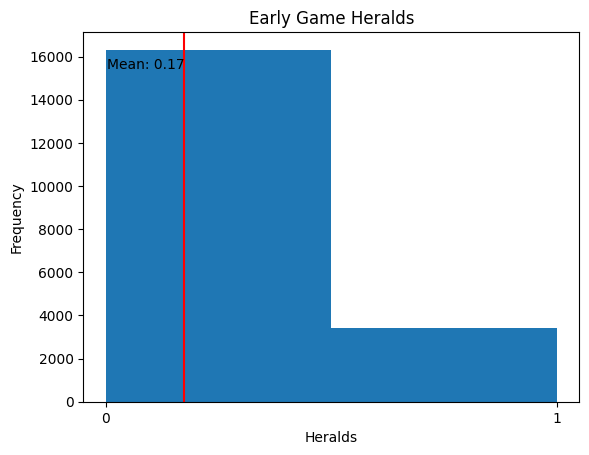

In [816]:
bar_plot_parameter(data, 'Heralds', 2)

Blue side

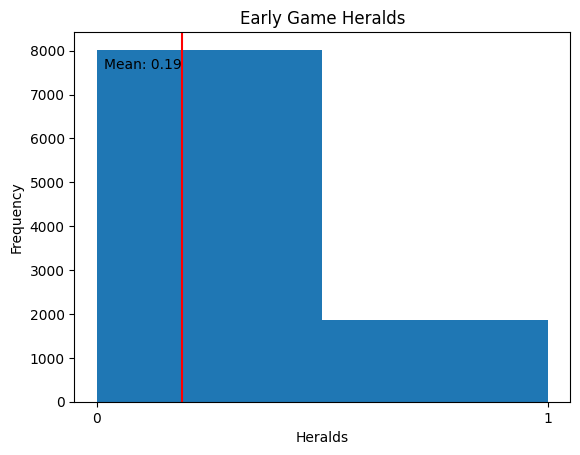

In [817]:
bar_plot_parameter(blue_df, 'Heralds', 2)

Red side

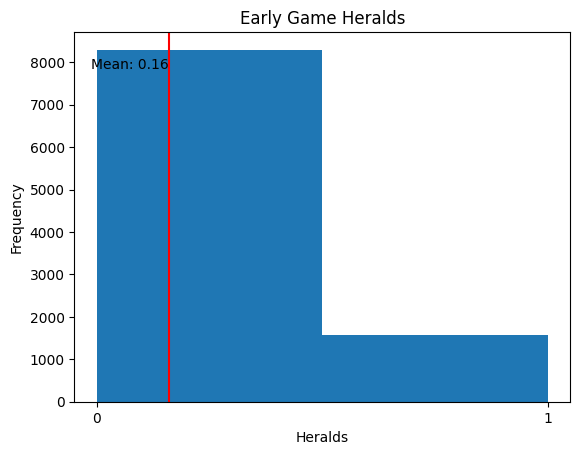

In [818]:
bar_plot_parameter(red_df, 'Heralds', 2)

In [819]:
#Ho: blue_mean = mu
#Ha: blue_mean > mu
alpha = 0.05
population_mean = np.mean(data['Heralds'])
population_sd = np.std(data['Heralds'])
sample_mean = np.mean(blue_df['Heralds'])
sample_n = len(blue_df['Heralds'])
z = (sample_mean - population_mean)/(population_sd/np.sqrt(sample_n))

z_critical = stats.norm.ppf(1-alpha)

In [820]:
z > z_critical

True

We consider the alternative hypothesis. Therefore, we can consider that the blue side could have an advantage when it comes to slaying the Herald

# Most impactful parameters that lead to winning

## Kills

Let's check the impact that early game kills have on the game

In [821]:
won = data[data['Wins']==1]
lost = data[data['Wins']==0]

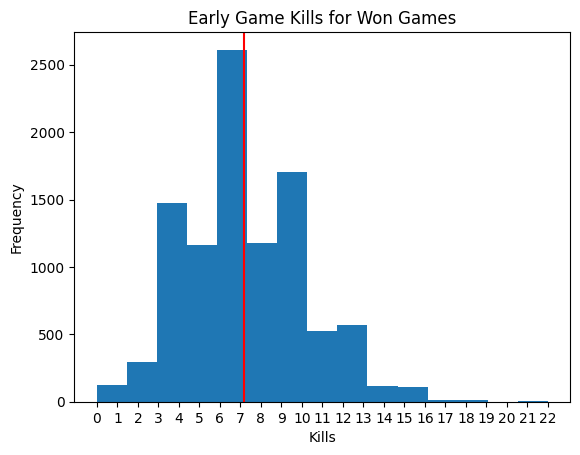

In [822]:
plt.hist(won['Kills'],15)
plt.xticks(range(0,max(data['Kills']+1)))
plt.title('Early Game Kills for Won Games')
plt.xlabel('Kills')
plt.ylabel('Frequency')
plt.axvline(np.mean(won['Kills']), color='red')
plt.show()

We can see that, on average, the early game kills matter when it comes to improving your chances of winning the game

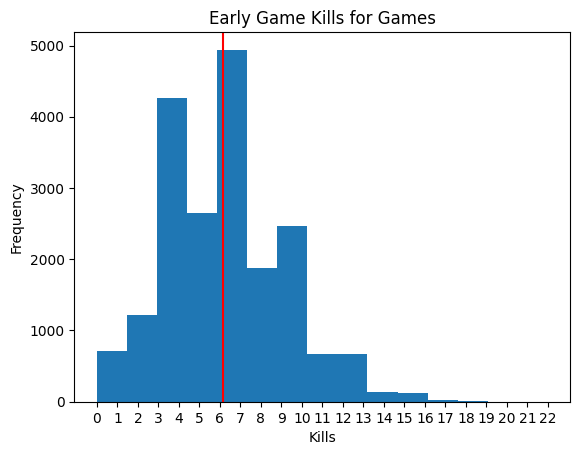

In [823]:
plt.hist(data['Kills'],15)
plt.title('Early Game Kills for Games')
plt.xlabel('Kills')
plt.ylabel('Frequency')
plt.xticks(range(0,max(data['Kills']+1)))
plt.axvline(np.mean(data['Kills']), color='red')
plt.show()

Let's run a test to see if the difference in the kill means is actually significant

Ho: mean_won = mean_all


Ha: mean_won > mean_all

In [824]:
population_mean = np.mean(data['Kills'])
population_sd = np.std(data['Kills'])
sample_mean = np.mean(won['Kills'])
sample_n = len(won['Wins'])

alpha = 0.0001 # 0.9999 confidence level

z = (sample_mean - population_mean)/(population_sd/np.sqrt(sample_n))
z_critical = stats.norm.ppf(1-alpha)

In [825]:
z > z_critical

True

Our value is in the rejection zone. We will reject the null hypothesis. Therefore, we can consider that there is a big gap between the average number of kills done in games that were won, compared to the whole population.

Let's see the correlation coefficient between the number of kills and games won

In [826]:
correlation, p_value = stats.pointbiserialr(y=data['Wins'], x=data['Kills'])

print(f"Point-Biserial Correlation: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

Point-Biserial Correlation: 0.3383
P-value: 0.0000


In [827]:
correlation_kills = correlation

In [828]:
def plot_x_axis(title, point):
    fig, ax = plt.subplots(figsize=(5, 1)) 

    ax.set_xlim(-1, 0)  


    ax.yaxis.set_visible(False)

    ax.axhline(0, color='black', linewidth=0.5)  
    ax.set_xticks([-1, 0, point, 1])
    ax.set_title(title)
    ax.yaxis.set_ticks([])

    plt.show()

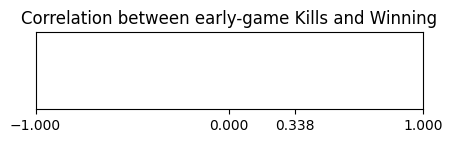

In [829]:
plot_x_axis('Correlation between early-game Kills and Winning', correlation)

There are reasons to believe that there is a very high correlation between the number of early-game kills and games won.

## First Bloods

Now let's analyze how much First Blood impacts the game

In [830]:
sum((data['Wins']==1) & (data['FirstBlood']==1))

5936

In [831]:
len(data[(data['Wins']==1) & (data['FirstBlood']==1)])

5936

In [832]:
n_w1_f1 = sum((data['Wins']==1) & (data['FirstBlood']==1)) #Number of games won with first blood
n_w0_f1 = sum((data['Wins']==0) & (data['FirstBlood']==1)) #Number of games lost with first blood
n_w1_f0 = sum((data['Wins']==1) & (data['FirstBlood']==0)) #Number of games lost without first blood
n_w0_f0 = sum((data['Wins']==0) & (data['FirstBlood']==0)) #Number of games lost without first blood
n_w1 = sum(data['Wins']==1)
n_w0 = sum(data['Wins']==0)
n_f1 = sum(data['FirstBlood']==1)
n_f0 = sum(data['FirstBlood']==0)

Let's see what % of games won drew a first blood

In [833]:
print((n_w1_f1 / n_w1)*100, '%')

60.087053345480314 %


60% of games won drew a first blood. Is this value enough to reason that there might be a correlation between first bloods and games won? Let's find the phi coefficient between them to find out.

In [834]:
phi = (n_w1_f1 * n_w0_f0 - n_w1_f0 * n_w0_f1)/np.sqrt((n_w1 * n_f1 * n_w0 * n_f0))
np.round(phi,5)

0.20174

In [835]:
correlation_first_blood = phi

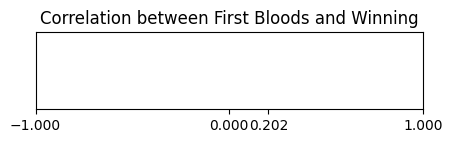

In [836]:
plot_x_axis('Correlation between First Bloods and Winning',phi)

We can suspect that there is a noticeable correlation between First Bloods and Wins, considering the phi value to be ~0.2

## Turrets Destroyed

Let's check the impact early pushing has to the game

In [837]:
correlation, p_value = stats.pointbiserialr(y=data['Wins'], x=data['TowersDestroyed'])

print(f"Point-Biserial Correlation: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

Point-Biserial Correlation: 0.1097
P-value: 0.0000


In [838]:
correlation_towers_destroyed = correlation

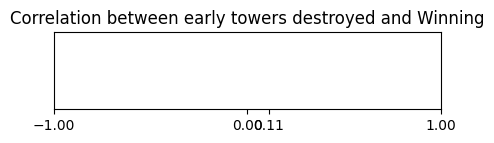

In [839]:
plot_x_axis('Correlation between early towers destroyed and Winning', correlation)

## All 

Let's make a list of the most important parameters and see their correlation to winning games

In [840]:
important_parameters = list(data.columns)
important_parameters.remove('gameId')
important_parameters.remove('Wins')
important_parameters.remove('FirstBlood')

In [841]:
d = {}

for parameter in important_parameters:
    correlation, p_value = stats.pointbiserialr(y=data['Wins'], x=data[parameter])
    d[parameter] = correlation

d['FirstBlood'] = correlation_first_blood

In [842]:
# Sorting the values
d = dict(sorted(d.items(), key=lambda item: item[1]))

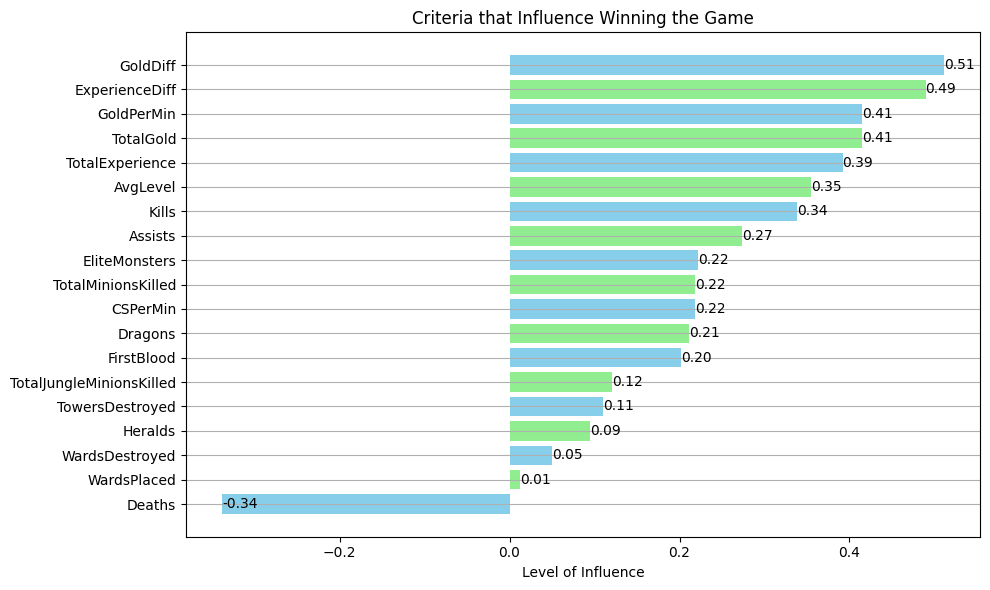

In [843]:
labels = list(d.keys())
values = list(d.values())


plt.figure(figsize=(10, 6))  
colors = ['skyblue' if i % 2 == 0 else 'lightgreen' for i in range(len(labels))]
bars = plt.barh(labels, values, color=colors)
plt.xlabel('Level of Influence')
plt.title('Criteria that Influence Winning the Game')
plt.grid(axis='x', linestyle='--', alpha=0.7)

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', va='center')

plt.grid()

plt.tight_layout()
plt.show()

# Regression Model

## First attempt

Let's make a model to predict the outcome on the game with the details every player has on their scoreboard:
- Dragons
- Heralds
- Towers
- Kills

In [844]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [845]:
X = data[['Kills', 'Dragons', 'Heralds', 'TowersDestroyed']]
Y = data['Wins']

Testing different data normalization tecnhiques to see which improves the accurracy of our model.

In [846]:
#NO NORMALIZATION

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
model = LogisticRegression()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred))
print("Classification Report:\n", classification_report(Y_test, Y_pred))

Accuracy: 0.6555742984204876
Confusion Matrix:
 [[2238 1058]
 [1188 2037]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.68      0.67      3296
           1       0.66      0.63      0.64      3225

    accuracy                           0.66      6521
   macro avg       0.66      0.66      0.66      6521
weighted avg       0.66      0.66      0.66      6521



In [847]:
#MIN MAX NORMALIZATION

for column in X.columns:
    X[column] = (X[column] - min(X[column]))/(max(X[column]) - min(X[column]))


In [848]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
model = LogisticRegression()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred))
print("Classification Report:\n", classification_report(Y_test, Y_pred))

Accuracy: 0.6548075448550835
Confusion Matrix:
 [[2240 1056]
 [1195 2030]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.68      0.67      3296
           1       0.66      0.63      0.64      3225

    accuracy                           0.65      6521
   macro avg       0.65      0.65      0.65      6521
weighted avg       0.65      0.65      0.65      6521



In [849]:
#Z-SCORE NORMALIZATION

for column in X.columns:
    X[column] = stats.zscore(X[column])

In [850]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
model = LogisticRegression()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred))
print("Classification Report:\n", classification_report(Y_test, Y_pred))

Accuracy: 0.6555742984204876
Confusion Matrix:
 [[2238 1058]
 [1188 2037]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.68      0.67      3296
           1       0.66      0.63      0.64      3225

    accuracy                           0.66      6521
   macro avg       0.66      0.66      0.66      6521
weighted avg       0.66      0.66      0.66      6521



Normalization has no effect on the accurracy of the model

In [851]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [852]:
model = LogisticRegression()
model.fit(X_train, Y_train)


LogisticRegression()

In [853]:
Y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred))
print("Classification Report:\n", classification_report(Y_test, Y_pred))

Accuracy: 0.6555742984204876
Confusion Matrix:
 [[2238 1058]
 [1188 2037]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.68      0.67      3296
           1       0.66      0.63      0.64      3225

    accuracy                           0.66      6521
   macro avg       0.66      0.66      0.66      6521
weighted avg       0.66      0.66      0.66      6521



## Second attempt

This is clearly not the best approach, as we do not have enough crucial parameters. A better approach would be to take the whole scoreboard information, both the ally and the enemy teams.

We need, again, to reorganize the dataframe. The plan is the following:
- We combine the blue and red teams back into a single dataframe, keeping both team's stats
- The stats will be renamed to 'Ally' and 'Enemy' stats, instead of 'Blue' and 'Red'
- To leave out the bias (Dragons, Heralds etc.) when it comes to the different sides, we will randomly select half of the blue teams to be Ally teams, and the other half to be Enemy teams

### Data manipulation

In [854]:
blue_ally = blue_df.sample(frac=0.5, random_state=1)
match_indexes = blue_ally.index

# Get the other half of the rows
red_ally = blue_df.drop(match_indexes)

In [855]:
blue_ally = blue_ally['gameId']
red_ally = red_ally['gameId']

Let's test if the 2 dataframes don't intersect

In [856]:
array1 = blue_ally.values.flatten()
array2 = red_ally.values.flatten()

# Find common values
common_values = np.intersect1d(array1, array2)
no_common_values = len(common_values) == 0
print(no_common_values)  # Output: True if no common values, False otherwise

True


Now let's check if we didn't lose any values

In [857]:
2*(len(blue_ally) + len(red_ally)) == len(data)

True

Of course, our dataframe length is halved, since we follow the original format again. We could also check the validity in the following way:

In [858]:
len(blue_ally) + len(red_ally) == len(df)

True

Let's combine the dataframes again

In [859]:
new_columns = ['Kills', 'Dragons', 'Heralds', 'TowersDestroyed']
for i in range(len(new_columns)):
    new_columns.append('enemy'+new_columns[i])
    new_columns[i] = 'ally'+new_columns[i]
new_columns.append('Wins')

In [860]:
new_columns


['allyKills',
 'allyDragons',
 'allyHeralds',
 'allyTowersDestroyed',
 'enemyKills',
 'enemyDragons',
 'enemyHeralds',
 'enemyTowersDestroyed',
 'Wins']

In [861]:
model_data = pd.DataFrame(columns=new_columns)

In [862]:
for gameid in blue_ally:
    data_values = df[df['gameId']==gameid]
    model_data.loc[gameid] = [data_values['blueKills'].values[0],data_values['blueDragons'].values[0], data_values['blueHeralds'].values[0], data_values['blueTowersDestroyed'].values[0], 
                              data_values['redKills'].values[0], data_values['redDragons'].values[0], data_values['redHeralds'].values[0], 
                              data_values['redTowersDestroyed'].values[0], data_values['blueWins'].values[0]]
    

In [863]:
for gameid in red_ally:
    data_values = df[df['gameId']==gameid]
    model_data.loc[gameid] = [data_values['redKills'].values[0], data_values['redDragons'].values[0], data_values['redHeralds'].values[0], data_values['redTowersDestroyed'].values[0],
                              data_values['blueKills'].values[0],data_values['blueDragons'].values[0], data_values['blueHeralds'].values[0],
                              data_values['blueTowersDestroyed'].values[0], (1 - data_values['blueWins'].values[0])]

In [864]:
model_data.head(-1)

,allyKills,allyDragons,allyHeralds,allyTowersDestroyed,enemyKills,enemyDragons,enemyHeralds,enemyTowersDestroyed,Wins
4522682981,10,0,0,0,1,0,0,0,1
4501445520,8,1,0,0,3,0,0,0,1
4513135937,9,1,0,0,3,0,0,0,1
4465078328,5,0,0,0,4,0,0,0,0
4494398674,4,0,0,0,3,1,1,0,1
...,...,...,...,...,...,...,...,...,...
4527780032,2,0,0,0,1,1,0,0,0
4527875317,12,0,1,0,9,1,0,0,1
4527715781,5,0,0,0,4,1,1,0,1
4527873286,4,0,0,0,7,1,0,0,0


### Model building

In [865]:
X = model_data[[col for col in model_data.columns if col!='Wins']]
Y = model_data['Wins']

In [866]:
for column in X.columns:
    X[column] = (X[column] - min(X[column]))/(max(X[column]) - min(X[column]))

In [867]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
model = LogisticRegression()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred))
print("Classification Report:\n", classification_report(Y_test, Y_pred))

Accuracy: 0.7019319227230911
Confusion Matrix:
 [[1107  516]
 [ 456 1182]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.68      0.69      1623
           1       0.70      0.72      0.71      1638

    accuracy                           0.70      3261
   macro avg       0.70      0.70      0.70      3261
weighted avg       0.70      0.70      0.70      3261



We have increased the original model's accuracy by about 5%.

In [868]:
def make_prediction(allyKills, allyDragons, allyHeralds, allyTowers, enemyKills, enemyDragons, enemyHeralds, enemyTowers):
    features = [[allyKills, allyDragons, allyHeralds, allyTowers, enemyKills, enemyDragons, enemyHeralds, enemyTowers]]
    rez = model.predict_proba(features)[0]
    prob_of_winning = np.round(rez[1],2)

    return prob_of_winning
    

In [869]:
make_prediction(allyKills=5, allyDragons=0, allyHeralds=0, allyTowers=0, 
                enemyKills=9, enemyDragons=1, enemyHeralds=0, enemyTowers=0)

0.0